# Diabetes Binary Classification

Objective: classify a diabetes diagnosis based on patients' data. We want to gain insights on different factors - such as demographics, lifestyle, medical history, medical measurements, medication, symtoms - that are associated to diabetes.

In [ ]:
!pip install import-ipynb
!pip install lightgbm
!pip install xgboost

## I. Import libraries and datasets

These are the libraries to import and common methods to use for the project.
* **pandas**. Useful for:
  * visualization 
    * `hist()`
  * normalization, 
  * merge and join, 
  * loading and savings 
    * `read_csv()`
  * data inspection
  * other
    * [`corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)
    * [`drop()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)
* **numpy**: fundamental package for scientific computing in Python.
  * `array()`
  * `squeeze()`
* **tensorflow** provides the model we can use to make the predication on our diabetes dataset
* **sklearn** basic library for data mining
  * metrics
    * [`confusion_matrix()`](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix)
    * `ConfusionMatrixDisplay()`
  * model_selection
    * [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Use `random_state` parameter to randomize the split selection.
  * preprocessing
    * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/preprocessing.html)
* **seaborn**. Useful for high level data visualization
  * `heatmap()`
  * [`pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
* **`matplotlib.pyplot`**: useful for plotting graphs in Pythong
  * `subplots()`

In [1]:
import import_ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow.keras as keras

from keras.layers import Dense
from keras.models import Sequential

from lightgbm import LGBMClassifier

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from utils_custom import *

importing Jupyter notebook from utils_custom.ipynb


## II. Describe and display the datasets

This dataset contains comprehensive health data for 1,879 patients, uniquely identified with IDs ranging from 6000 to 7878. The data includes demographic details, lifestyle factors, medical history, clinical measurements, medication usage, symptoms, quality of life scores, environmental exposures, and health behaviors. Each patient is associated with a confidential doctor in charge, ensuring privacy and confidentiality.

[Data source: Diabetes Health Dataset Analysis](https://www.kaggle.com/datasets/rabieelkharoua/diabetes-health-dataset-analysis/data)

We will read the diabetes medical information from a .csv file

In [2]:
diabetes_df = pd.read_csv('diabetes_data.csv')

We will view the firs five rows of the dataset. We also want to display the info to show the column labels, non-empty cells count and the datatypes.

In [3]:
diabetes_df.head(5)

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,6000,44,0,1,2,1,32.985284,1,4.499365,2.443385,...,1,73.765109,0,0,0,1.782724,4.486980,7.211349,1,Confidential
1,6001,51,1,0,1,2,39.916764,0,1.578919,8.301264,...,0,91.445753,0,0,1,3.381070,5.961705,5.024612,1,Confidential
2,6002,89,1,0,1,3,19.782251,0,1.177301,6.103395,...,0,54.485744,0,0,0,2.701019,8.950821,7.034944,0,Confidential
3,6003,21,1,1,1,2,32.376881,1,1.714621,8.645465,...,0,77.866758,0,0,1,1.409056,3.124769,4.717774,0,Confidential
4,6004,27,1,0,1,3,16.808600,0,15.462549,4.629383,...,0,37.731808,0,0,0,1.218452,6.977741,7.887940,0,Confidential


Let's print out the summary of the diabetes dataframe. This summary will include the column labels, non-null count and the datatype included in the diabetes dataset. We can see that there are 46 labels or features. We can also note that every feauture does not contain an empty data. We can verify that by looking at the non-null count column.

In [4]:
diabetes_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PatientID                      1879 non-null   int64  
 1   Age                            1879 non-null   int64  
 2   Gender                         1879 non-null   int64  
 3   Ethnicity                      1879 non-null   int64  
 4   SocioeconomicStatus            1879 non-null   int64  
 5   EducationLevel                 1879 non-null   int64  
 6   BMI                            1879 non-null   float64
 7   Smoking                        1879 non-null   int64  
 8   AlcoholConsumption             1879 non-null   float64
 9   PhysicalActivity               1879 non-null   float64
 10  DietQuality                    1879 non-null   float64
 11  SleepQuality                   1879 non-null   float64
 12  FamilyHistoryDiabetes          1879 non-null   i

We can also use `Dataframe.notna()` to check if every patient's data is completely filled. In the case that we detect an incomplete data, we can do either of these two things:
1. We can remove that data from the set, OR
2. We have to go through another step of collaborative filtering to guess the closest possible value

In this step, since we verified that every data is complete, we can just proceed to the next process.

We can use `describe()` method to highlight the average, lowest and highest value in each feature.

In [5]:
diabetes_df.describe()

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,SlowHealingSores,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,...,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,6939.000000,55.043108,0.487493,0.755721,0.992017,1.699308,27.687601,0.281533,10.096587,5.200790,...,0.102714,0.111229,48.508643,0.052155,0.103246,0.200639,1.997101,4.957539,5.011736,0.400213
std,542.564896,20.515839,0.499977,1.047558,0.764940,0.885665,7.190975,0.449866,5.914216,2.857012,...,0.303666,0.314500,28.758488,0.222400,0.304361,0.400585,1.122632,2.910934,2.920908,0.490072
min,6000.000000,20.000000,0.000000,0.000000,0.000000,0.000000,15.025898,0.000000,0.000928,0.004089,...,0.000000,0.000000,0.002390,0.000000,0.000000,0.000000,0.004013,0.005384,0.000362,0.000000
25%,6469.500000,38.000000,0.000000,0.000000,0.000000,1.000000,21.469981,0.000000,4.789725,2.751022,...,0.000000,0.000000,23.974098,0.000000,0.000000,0.000000,1.057801,2.420024,2.410113,0.000000
50%,6939.000000,55.000000,0.000000,0.000000,1.000000,2.000000,27.722988,0.000000,10.173865,5.249002,...,0.000000,0.000000,47.519693,0.000000,0.000000,0.000000,1.987170,4.843886,5.035208,0.000000
75%,7408.500000,73.000000,1.000000,1.000000,2.000000,2.000000,33.856460,1.000000,15.285359,7.671402,...,0.000000,0.000000,72.883179,0.000000,0.000000,0.000000,2.946019,7.513933,7.586865,1.000000
max,7878.000000,90.000000,1.000000,3.000000,2.000000,3.000000,39.998811,1.000000,19.996231,9.993893,...,1.000000,1.000000,99.788530,1.000000,1.000000,1.000000,3.999715,9.997165,9.993029,1.000000


In [6]:
ave_age = diabetes_df['Age'].mean()
diag_ct = diabetes_df['Diagnosis'].sum()
pos_per = diag_ct.sum()/len(diabetes_df) * 100
female_ct = diabetes_df['Gender'].sum()
female_per = female_ct.sum()/len(diabetes_df) * 100
male_per = 100 - female_per

In [7]:
print(f"The average age is {ave_age:.2f} years old.")
print(f"There are {female_per:.2f}% females and {male_per:.2f}% males.")
print(f"There are {pos_per:.2f}% diagnosed as diabetic.")

The average age is 55.04 years old.
There are 48.75% females and 51.25% males.
There are 40.02% diagnosed as diabetic.


Before we visualize our data, we noticed that we do not need some columns like PatienID and DoctorInCharge. We can drop these columns from the original data.

Note: If you are getting a Keyerror because of the labels, PatientID and DoctorInCharge are not in axis, this means that you probably have removed the columns already from your run previously. In this case, you can ignore and go to the next step.

In [8]:
diabetes_df = diabetes_df.drop(columns=['PatientID', 'DoctorInCharge'])

### III. Visualize data

We will be using data visualization library, `seaborn` to help us identify which features in our dataset can affect greatly with the diabetes classification. 

1. In this data, we can see the distribution in each features. For example in the `Diagnosis` chart (the last chart at the bottom), we can see graphically that there are more patients in our dataset that do not have diabetes. We can also see that there are ~750 patients that are diagnosed with diabetes. We can also take note that more than 50% are male. Majority of the patients in this dataset are Caucasion. There are also high number of patients belonging in the middle class. Majority have high school and undergraduate degrees. Most are non-smokers, no family history of diabetes,, no gestationsl diabetes, no polycystic ovary syndrome, no previous predisposed diabetes, no hypertension.

Here, we want to see the profile of patients with diabetes. We notice that majority of patients with diabetes has high readings of FastingBloodSugar and HbA1c.

2. Another way of visualizing out data is by using the correlation function. `corr()` is another way of visualizing correlationship between a pair of features and the `Diagnosis` results. We will ignore the white diagonal line because it's just trying to find similarity with itself. But we can look at lighter and brighter colors to find the most similar features.

3. The blue dot represents the patients who were not diagnosed with diabetes. The orange dot represents patients who are diagnosed with diabetes.

4. Let's take a look at how our dataset looks on a 3d plot using _FastingBloodSugar_ ,  _HbA1c_ and _Diagnosis_. We can observe that the dataset on the top layer are patients diagnosed with diabetes. We can observe that there is a clump forming on the top right quadrant with many outliers sparsely spread out.

We narrow down the features and join them in strong_features. Here we can notice that `FastingBloodSugar` and `HbA1c` has strong influence on the diabetic results.

In [109]:
selected_features = [
                   'Age',
                   'BMI', 
#                    'AlcoholConsumption', 
#                    'PhysicalActivity', 
#                    'DietQuality', 
#                    'SleepQuality',
#                    'SystolicBP', 
#                    'DiastolicBP',
                   'FastingBloodSugar', 
                   'HbA1c', 
#                    'SerumCreatinine', 
#                    'BUNLevels', 
#                    'CholesterolTotal',
#                    'CholesterolLDL', 
#                    'CholesterolHDL',
#                    'CholesterolTriglycerides',
#                    'AntidiabeticMedications',
                    ]

Run this line if you want to visualize the diabetes data in histogram, heatmap, pairplot and 3D scatterplot.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

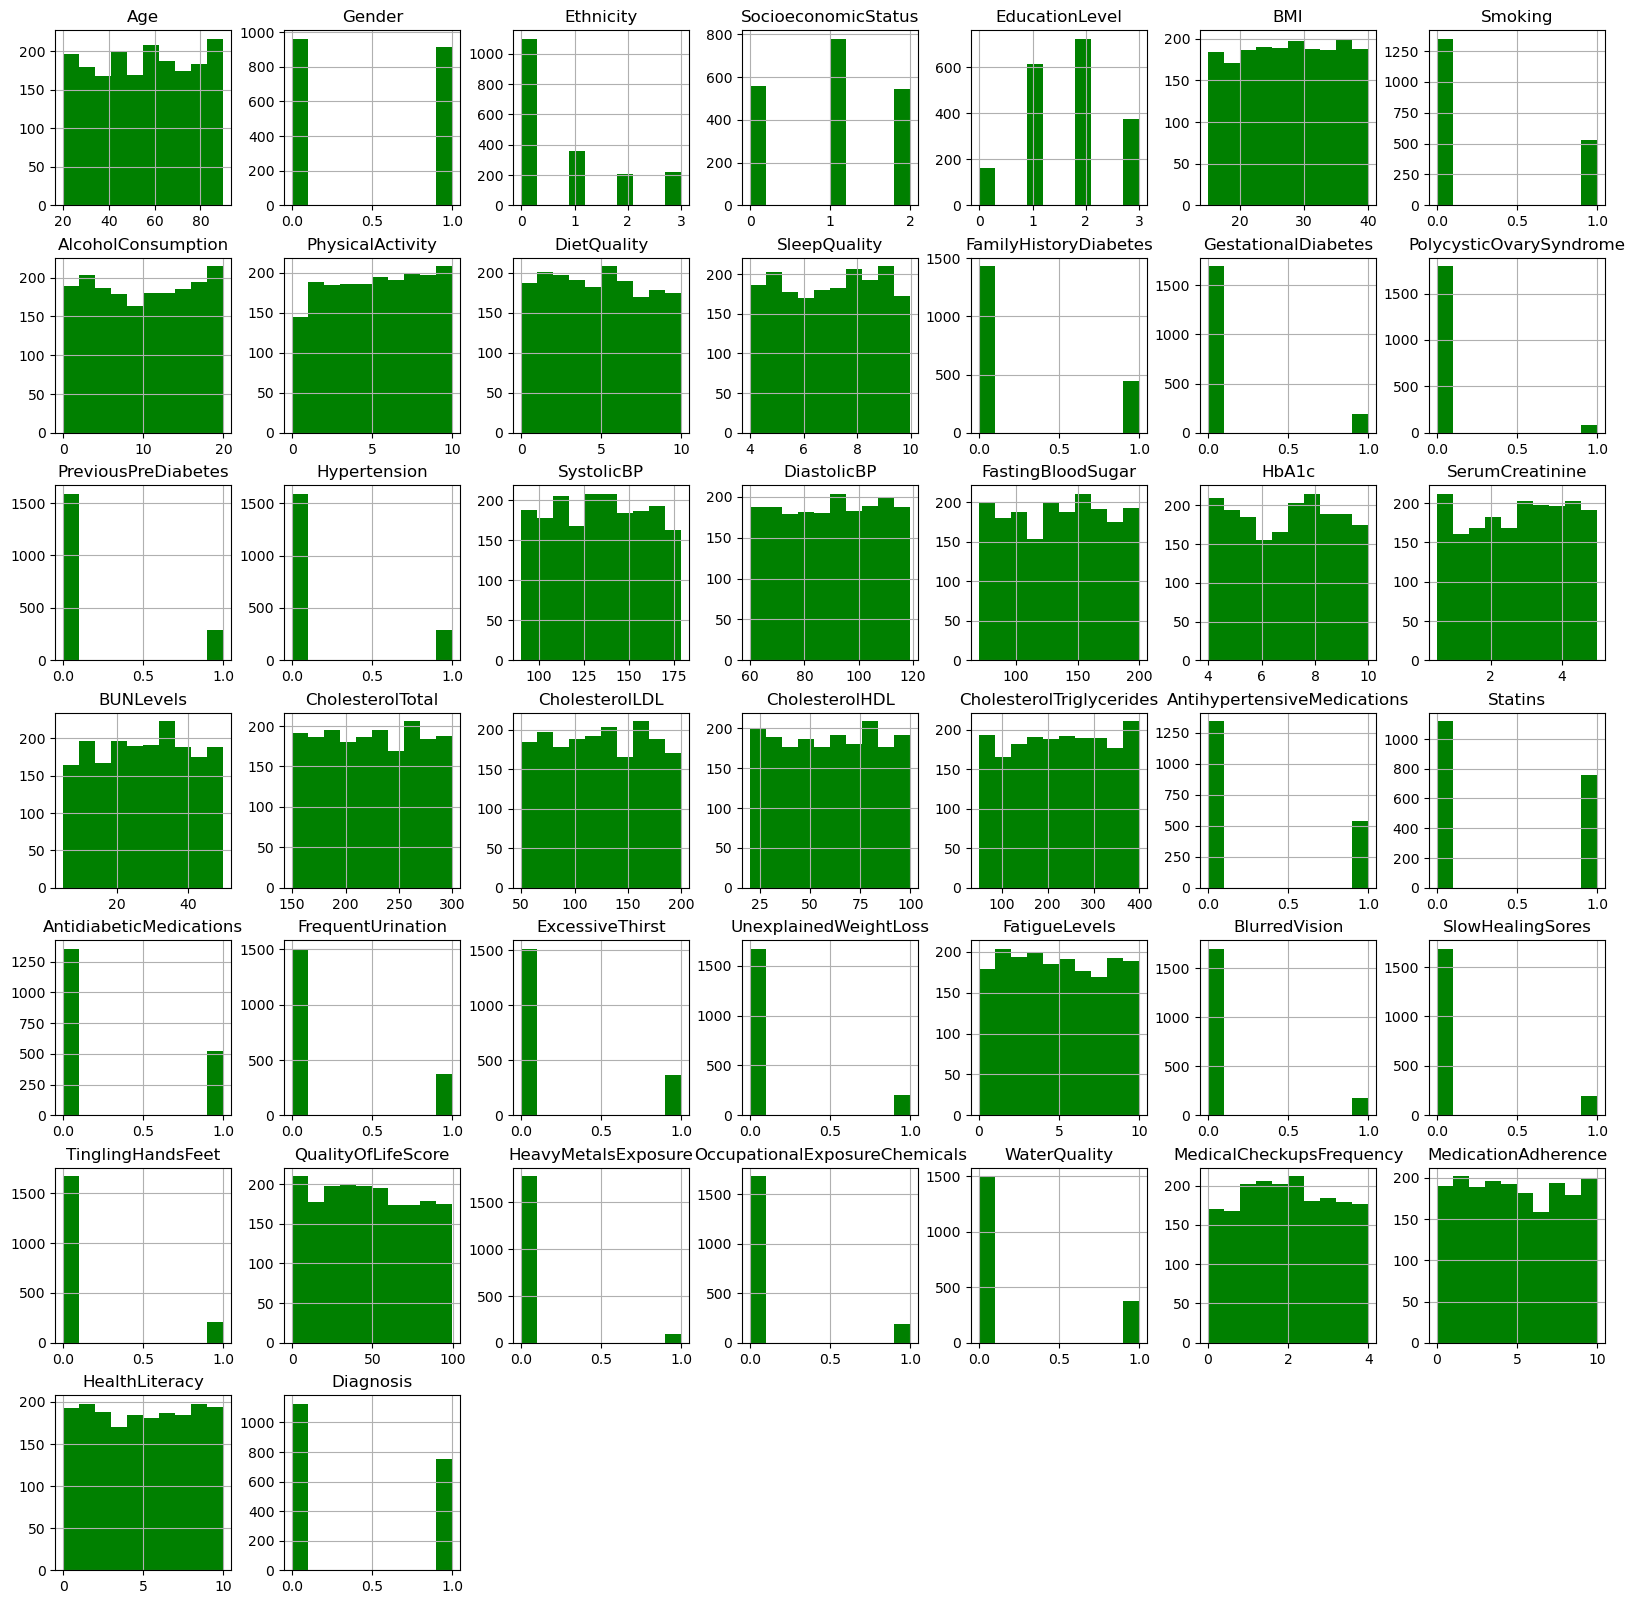

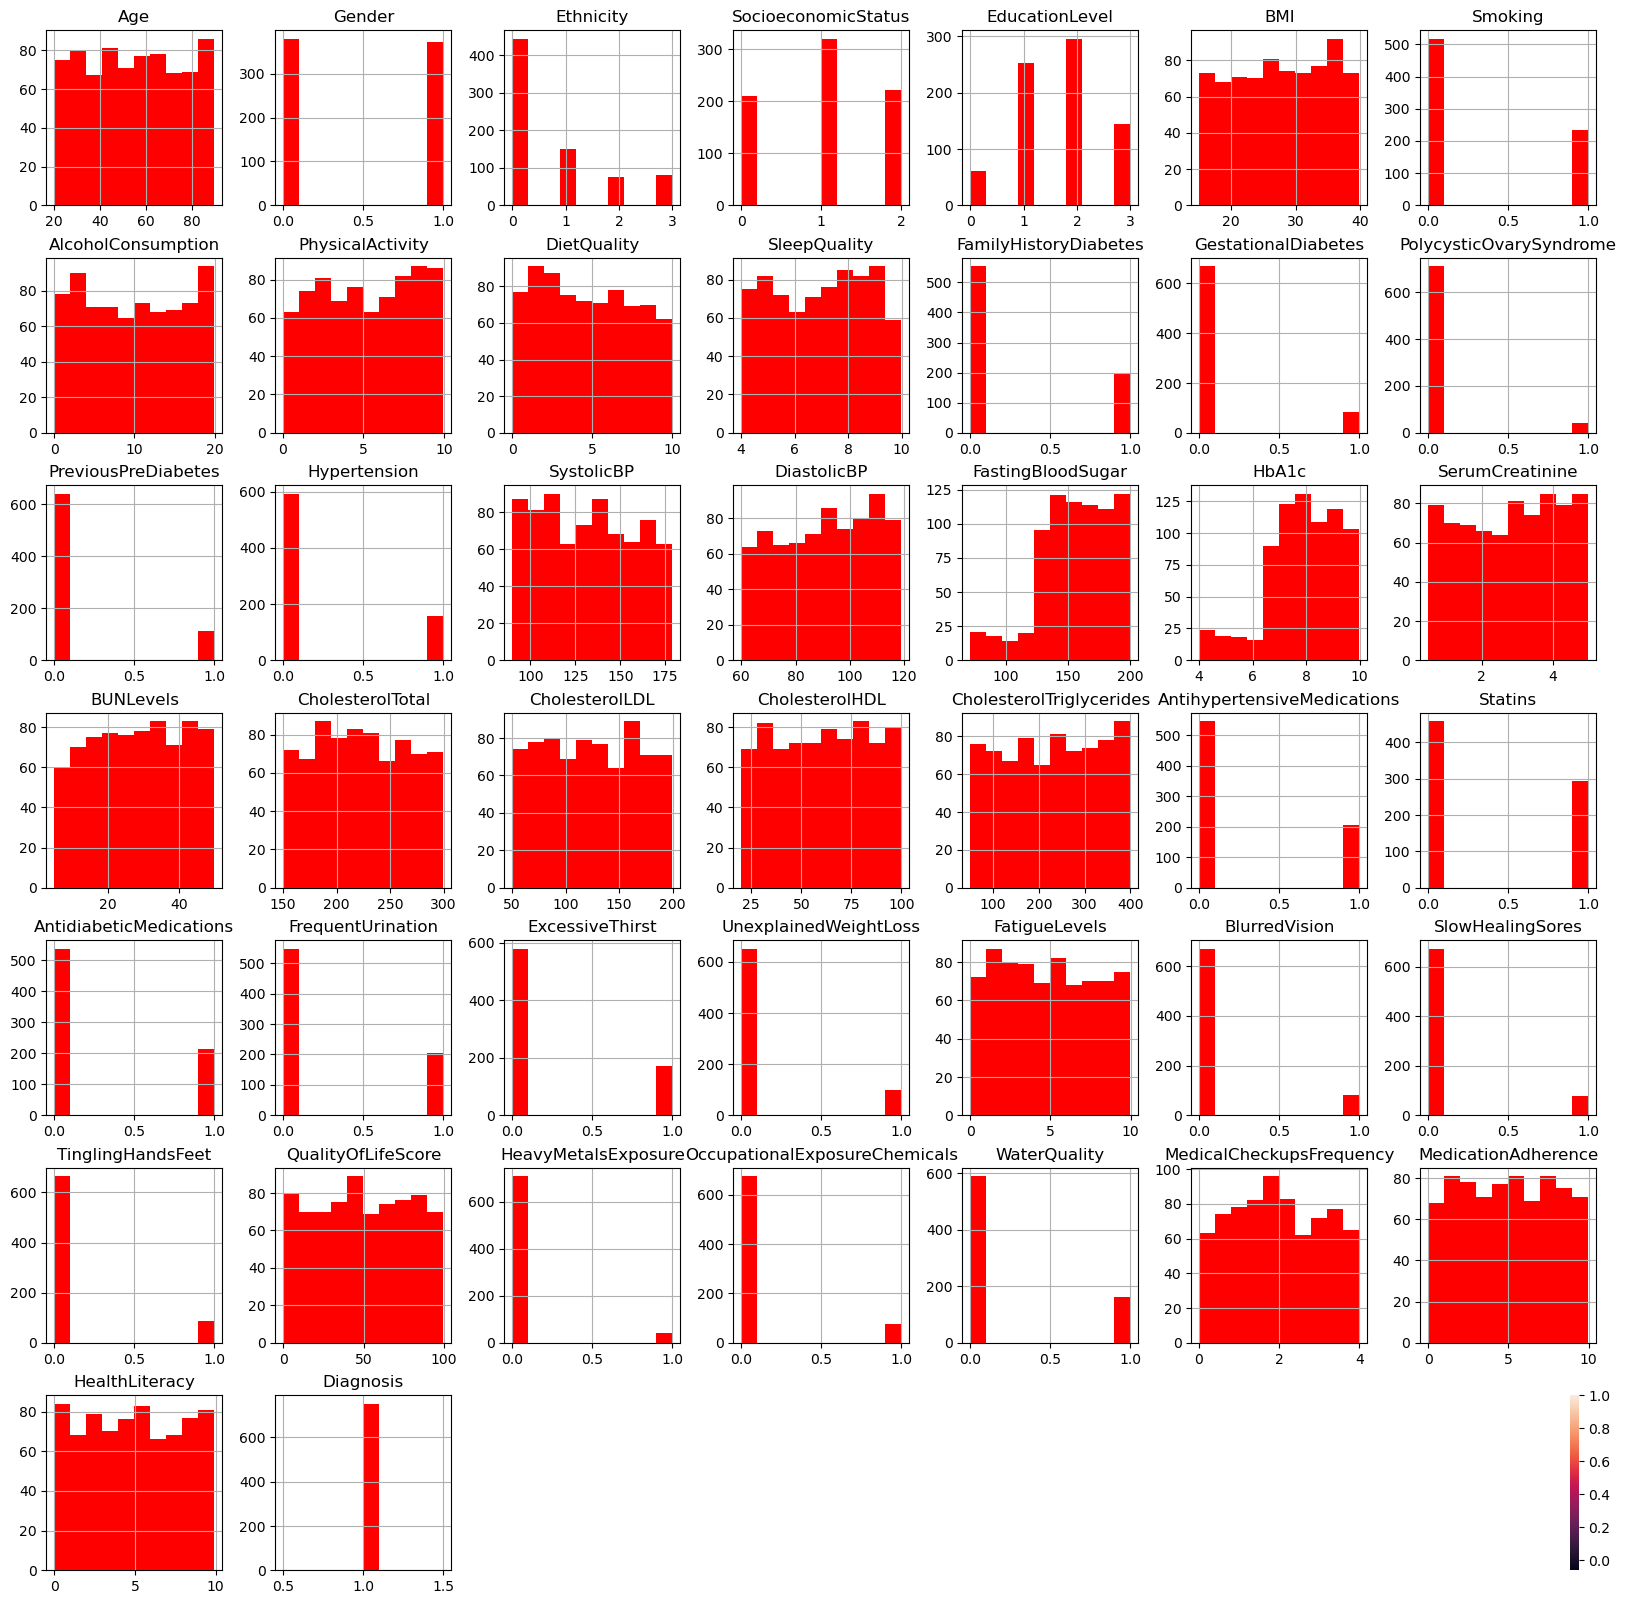

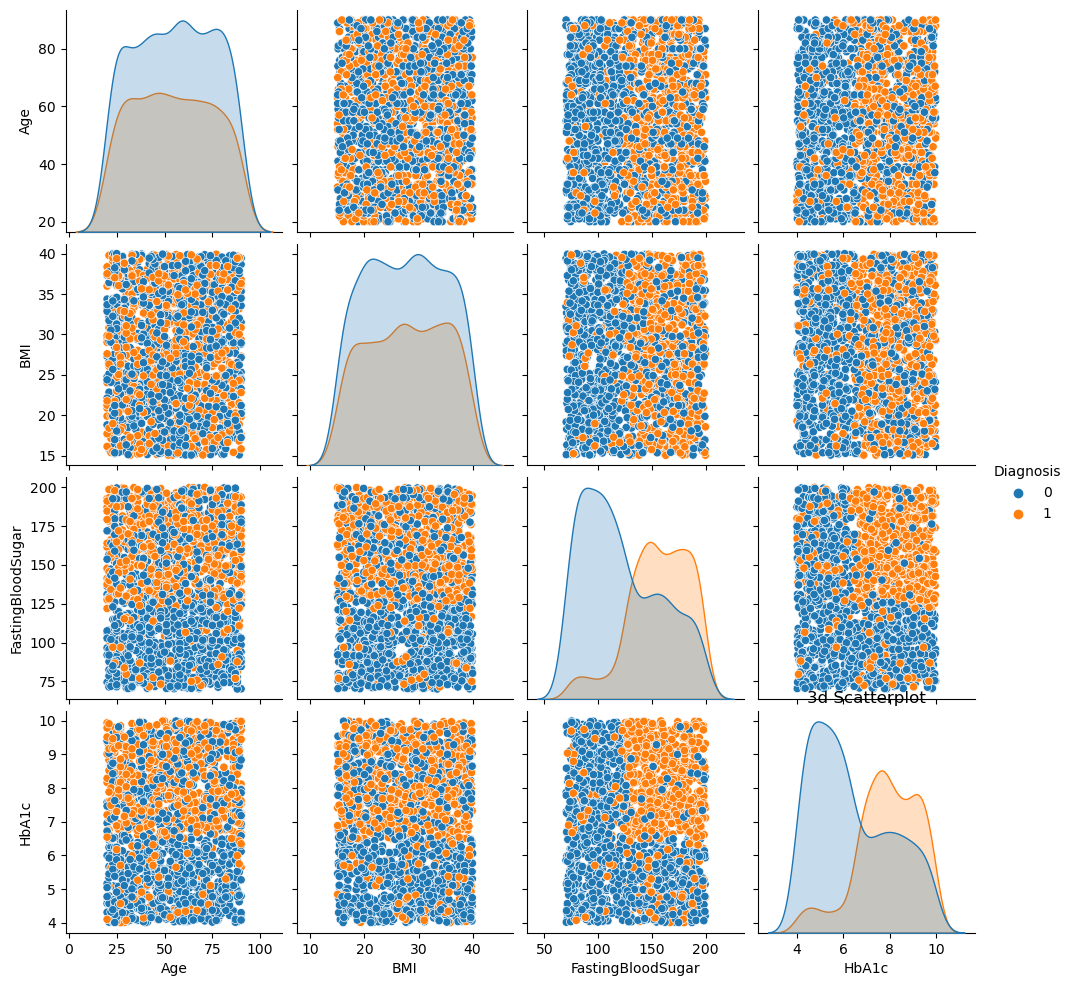

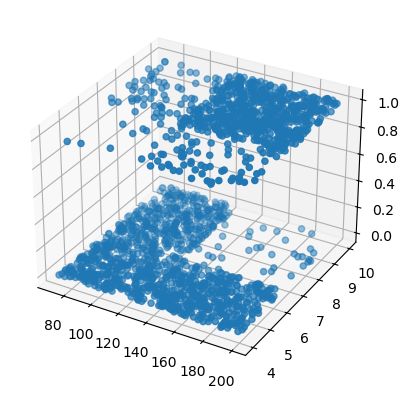

In [110]:
visualize_data(diabetes_df, selected_features)

## Feature Engineering
1. Possible Engineered feature we can use is the ratio of Systolic and Diastolic Blood Pressure.

In [111]:
systolic = diabetes_df['SystolicBP']
diastolic = diabetes_df['DiastolicBP']
bloodPressure = (systolic / diastolic)
bloodPressure = pd.DataFrame({'BloodPressure': bloodPressure})

In [112]:
# diabetes_df = diabetes_df.drop(columns='BloodPressure')
# diabetes_df.insert(43, 'BloodPressure', bloodPressure)

Then, we will add the new features in our selected feature list.

In [113]:
# new_features = ['BloodPressure']
# selected_features.extend(new_features)
selected_features

['Age', 'BMI', 'FastingBloodSugar', 'HbA1c']

We found out that adding this feature did not improve our prediction model.

### IV. Preprocessing

#### Scaling the data

We need to separate the inputs and the output. The X input should contain all of the selected features, except for the `Diagnosis`. The output should contain the `Diagnosis` results, 0 for not diabetic and 1 for diabetic. The output _y_ will be the groundtruth for our model later.

In [114]:
X = diabetes_df[selected_features]
X

,Age,BMI,FastingBloodSugar,HbA1c
0,44,32.985284,163.687162,9.283631
1,51,39.916764,188.347070,7.326870
2,89,19.782251,127.703653,4.083426
3,21,32.376881,82.688415,6.516645
4,27,16.808600,90.743395,5.607222
...,...,...,...,...
1874,37,20.811137,109.832032,5.920723
1875,80,27.694312,90.729361,7.332397
1876,38,35.640824,149.366801,4.907208
1877,43,32.423016,162.027044,8.820613


In [115]:
Y = diabetes_df['Diagnosis']

To scale, we will be using the `MinMaxScaler` from sci-kit learn. `MinMaxScaler()` will narrow down the range of values in each feature.

`MinMaxScaler()` transforms features by scaling each feature to a given range.

`fit_transform()` learns the parameters and apply the transformation to new data

In [116]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,Age,BMI,FastingBloodSugar,HbA1c
0,0.342857,0.719155,0.720868,0.881839
1,0.442857,0.996715,0.910763,0.555064
2,0.985714,0.190460,0.443775,0.013416
3,0.014286,0.694792,0.097133,0.419758
4,0.100000,0.071385,0.159161,0.267887
...,...,...,...,...
1874,0.242857,0.231661,0.306154,0.320241
1875,0.857143,0.507286,0.159053,0.555987
1876,0.257143,0.825491,0.610593,0.150986
1877,0.328571,0.696640,0.708084,0.804516


#### Splitting data
We want to split our datasets into three:
| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |

In [117]:
X_train, y_train, X_cv, y_cv, X_test, y_test = split_dataset(X_scaled, Y)
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape

((1127, 4), (1127,), (376, 4), (376,), (376, 4), (376,))

### V. Adding Polynomial feature (Optional)

NOTE: Do not run part V if you don't want to add polynomial feature on your selected features.

We will generate polynomial features from our training set using `PolynomialFeatures()`

Training set
1. Initiate Polynomial Features
2. Add the polynomial features in the training set using _fit_transform()_
3. Scale the training set
4. Create and train model. We will use _LinearRegression_ for the model and we will use _fit()_ to train the set with the model.
5. Compute the _Mean Square Error_

Cross-Validation and Testing set
1. Add polynomial features and scale using _transform()_
2. Compute the _Mean Square Error_

##### fit() vs transform() vs fit_transform()
* _fit()_ learn and estimate the parameters fo the transformation
* _transform()_ apply the learned transformation to new data
* _fit_transform()_ learn the parameters and apply the transformation to new data.

In [118]:
degrees = range(1, 8)
datasets = [X_train, y_train, X_cv, y_cv, X_test, y_test]
maps, mses = poly_optimizer(degrees, datasets)

1 (1127, 4) (376, 4) (376, 4)
2 (1127, 14) (376, 14) (376, 14)
3 (1127, 34) (376, 34) (376, 34)
4 (1127, 69) (376, 69) (376, 69)
5 (1127, 125) (376, 125) (376, 125)
6 (1127, 209) (376, 209) (376, 209)
7 (1127, 329) (376, 329) (376, 329)


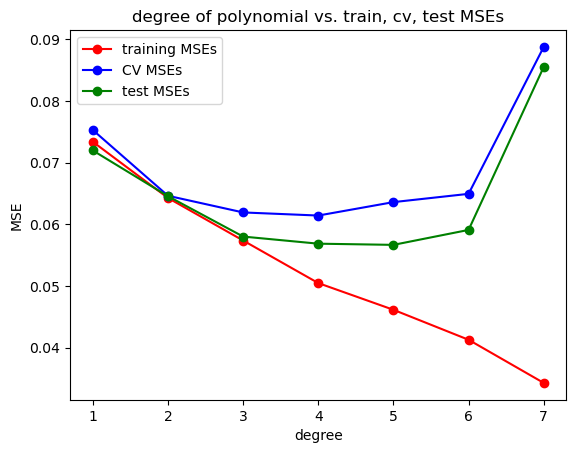

In [119]:
# Plot the results
plot_train_cv_test_mses(degrees, mses['train'], mses['cv'], mses['test'], title="degree of polynomial vs. train, cv, test MSEs")

### Choosing the Polynomial Feature to add to our data

In [120]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added

deg = np.argmin(mses['cv'])

X_train = maps['train'][deg]
X_cv = maps['cv'][deg]
X_test = maps['test'][deg]

train_mse = mses['train'][deg]
cv_mse = mses['cv'][deg]
test_mse = mses['test'][deg]

print(f"Lowest CV MSE is found in the model with degree={deg + 1} with {cv_mse:.2f} mse")

Lowest CV MSE is found in the model with degree=4 with 0.06 mse


### VI. Training the classification models
Here, we will be looking at 3 different architectures of neural network. This is how we build the models in `build_models()`:
| Model Name       | # of Hidden Layers |  Activation layers                     |
|------------------|:------------------:|:--------------------------------------:|
| Model_1          | 3                  | (relu, relu, sigmoid)                  |
| Model_2          | 5                  | (relu, relu, relu, relu, sigmoid)      |
| Model_3          | 6                  | (relu, relu, relu, relu, relu, sigmoid)|

We want the input to be the same length as our features. For the output, we want the size to be 1 since we just want a binary output, either 0 or 1. For binary classification, we want to use 'sigmoid' rather than 'linear' for the final neuron.

In [121]:
rows_len = X_train.shape[1]
rows_len = (rows_len, )
regularizer = 1e-5 # best
# regularizer = 1e3

models = build_models(rows_len, regularizer)

for model_name, model in models.items():
    model.summary()

build_models


Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 14)             │           980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,173 (4.58 KB)

 Trainable params: 1,173 (4.58 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 20)             │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 12)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 20)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,089 (8.16 KB)

 Trainable params: 2,089 (8.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 32)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013 (11.77 KB)

 Trainable params: 3,013 (11.77 KB)

 Non-trainable params: 0 (0.00 B)

For the loss function, we want to use binary entropy rather than 'mean square error'). We also want to monitor the accuracy of our model for each epoch.

In [122]:
histories = []
for model_name, model in models.items():
    print(f"Training with {model_name}")
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    history = model.fit(X_train, 
                      y_train, 
                      epochs = 100, 
                      batch_size = 50,
                      validation_data = (X_cv, y_cv) )
    histories.append(history)

Training with Model_1
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5209 - loss: 0.6913 - mse: 0.2489 - val_accuracy: 0.7287 - val_loss: 0.6587 - val_mse: 0.2327
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7531 - loss: 0.6507 - mse: 0.2288 - val_accuracy: 0.8271 - val_loss: 0.6088 - val_mse: 0.2082
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.8144 - loss: 0.5975 - mse: 0.2029 - val_accuracy: 0.8245 - val_loss: 0.5456 - val_mse: 0.1790
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.8407 - loss: 0.5320 - mse: 0.1729 - val_accuracy: 0.8191 - val_loss: 0.4898 - val_mse: 0.1561
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.8500 - loss: 0.4704 - mse: 0.1470 - val_accuracy: 0.8271 - val_loss: 0.4547 - val_mse: 0.1433
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.8474 - loss: 0.4301 - mse: 0.1317 - val_accuracy: 0.8191 - val_loss: 0.4344 - val_mse: 0.1360
Epoch 7/100
23

Epoch 43/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8794 - loss: 0.3314 - mse: 0.0965 - val_accuracy: 0.8803 - val_loss: 0.3638 - val_mse: 0.1051
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.8794 - loss: 0.3305 - mse: 0.0962 - val_accuracy: 0.8803 - val_loss: 0.3638 - val_mse: 0.1051
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.8782 - loss: 0.3299 - mse: 0.0961 - val_accuracy: 0.8803 - val_loss: 0.3637 - val_mse: 0.1050
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.8782 - loss: 0.3291 - mse: 0.0959 - val_accuracy: 0.8803 - val_loss: 0.3635 - val_mse: 0.1050
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.8786 - loss: 0.3284 - mse: 0.0957 - val_accuracy: 0.8803 - val_loss: 0.3633 - val_mse: 0.1049
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.8786 - loss: 0.3277 - mse: 0.0955 - val_accuracy: 0.8803 - val_loss: 0.3633 - val_mse: 0.1049
Epoch 49/100
23/23 ━━━━━━━━━

Epoch 85/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8904 - loss: 0.3027 - mse: 0.0893 - val_accuracy: 0.8777 - val_loss: 0.3625 - val_mse: 0.1046
Epoch 86/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.8904 - loss: 0.3022 - mse: 0.0892 - val_accuracy: 0.8777 - val_loss: 0.3627 - val_mse: 0.1046
Epoch 87/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.8904 - loss: 0.3017 - mse: 0.0891 - val_accuracy: 0.8777 - val_loss: 0.3628 - val_mse: 0.1046
Epoch 88/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.8891 - loss: 0.3008 - mse: 0.0888 - val_accuracy: 0.8777 - val_loss: 0.3630 - val_mse: 0.1047
Epoch 89/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.8904 - loss: 0.3010 - mse: 0.0890 - val_accuracy: 0.8777 - val_loss: 0.3629 - val_mse: 0.1045
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.8904 - loss: 0.3000 - mse: 0.0887 - val_accuracy: 0.8777 - val_loss: 0.3631 - val_mse: 0.1046
Epoch 91/100
23/23 ━━━━━━━━━

Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.8774 - loss: 0.3303 - mse: 0.0970 - val_accuracy: 0.8750 - val_loss: 0.3592 - val_mse: 0.1048
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.8749 - loss: 0.3290 - mse: 0.0968 - val_accuracy: 0.8750 - val_loss: 0.3588 - val_mse: 0.1046
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.8749 - loss: 0.3273 - mse: 0.0963 - val_accuracy: 0.8750 - val_loss: 0.3583 - val_mse: 0.1045
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.8749 - loss: 0.3252 - mse: 0.0957 - val_accuracy: 0.8750 - val_loss: 0.3580 - val_mse: 0.1044
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.8761 - loss: 0.3236 - mse: 0.0952 - val_accuracy: 0.8750 - val_loss: 0.3578 - val_mse: 0.1045
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.8738 - loss: 0.3229 - mse: 0.0952 - val_accuracy: 0.8750 - val_loss: 0.3575 - val_mse: 0.1043
Epoch 33/100
23/23 ━━━━━━━━━

Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8848 - loss: 0.2870 - mse: 0.0859 - val_accuracy: 0.8723 - val_loss: 0.3695 - val_mse: 0.1064
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8869 - loss: 0.2861 - mse: 0.0855 - val_accuracy: 0.8723 - val_loss: 0.3697 - val_mse: 0.1063
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.8860 - loss: 0.2860 - mse: 0.0857 - val_accuracy: 0.8723 - val_loss: 0.3694 - val_mse: 0.1065
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.8844 - loss: 0.2853 - mse: 0.0855 - val_accuracy: 0.8723 - val_loss: 0.3690 - val_mse: 0.1060
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.8871 - loss: 0.2839 - mse: 0.0849 - val_accuracy: 0.8723 - val_loss: 0.3706 - val_mse: 0.1063
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8866 - loss: 0.2836 - mse: 0.0849 - val_accuracy: 0.8723 - val_loss: 0.3718 - val_mse: 0.1065
Epoch 75/100
23/23 ━━━━━━━━━

Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6186 - loss: 0.6692 - mse: 0.2379 - val_accuracy: 0.6011 - val_loss: 0.6740 - val_mse: 0.2403
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.6186 - loss: 0.6685 - mse: 0.2376 - val_accuracy: 0.6011 - val_loss: 0.6737 - val_mse: 0.2402
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.6186 - loss: 0.6680 - mse: 0.2373 - val_accuracy: 0.6011 - val_loss: 0.6735 - val_mse: 0.2401
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.6186 - loss: 0.6676 - mse: 0.2372 - val_accuracy: 0.6011 - val_loss: 0.6734 - val_mse: 0.2400
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.6186 - loss: 0.6673 - mse: 0.2370 - val_accuracy: 0.6011 - val_loss: 0.6733 - val_mse: 0.2400
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.6186 - loss: 0.6671 - mse: 0.2369 - val_accuracy: 0.6011 - val_loss: 0.6732 - val_mse: 0.2399
Epoch 17/100
23/23 ━━━━━━━━━

Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.8766 - loss: 0.4388 - mse: 0.1366 - val_accuracy: 0.8777 - val_loss: 0.4557 - val_mse: 0.1414
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.8753 - loss: 0.4364 - mse: 0.1356 - val_accuracy: 0.8803 - val_loss: 0.4533 - val_mse: 0.1402
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.8742 - loss: 0.4334 - mse: 0.1342 - val_accuracy: 0.8803 - val_loss: 0.4508 - val_mse: 0.1389
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.8775 - loss: 0.4295 - mse: 0.1325 - val_accuracy: 0.8803 - val_loss: 0.4482 - val_mse: 0.1377
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.8792 - loss: 0.4253 - mse: 0.1307 - val_accuracy: 0.8830 - val_loss: 0.4460 - val_mse: 0.1367
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.8771 - loss: 0.4231 - mse: 0.1299 - val_accuracy: 0.8803 - val_loss: 0.4440 - val_mse: 0.1358
Epoch 59/100
23/23 ━━━━━━━━━

Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.8911 - loss: 0.3397 - mse: 0.0989 - val_accuracy: 0.8830 - val_loss: 0.4076 - val_mse: 0.1171
Epoch 96/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8914 - loss: 0.3375 - mse: 0.0980 - val_accuracy: 0.8830 - val_loss: 0.4072 - val_mse: 0.1168
Epoch 97/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.8914 - loss: 0.3367 - mse: 0.0979 - val_accuracy: 0.8803 - val_loss: 0.4073 - val_mse: 0.1168
Epoch 98/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.8914 - loss: 0.3354 - mse: 0.0974 - val_accuracy: 0.8803 - val_loss: 0.4067 - val_mse: 0.1164
Epoch 99/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.8911 - loss: 0.3339 - mse: 0.0969 - val_accuracy: 0.8803 - val_loss: 0.4064 - val_mse: 0.1162
Epoch 100/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.8914 - loss: 0.3322 - mse: 0.0963 - val_accuracy: 0.8830 - val_loss: 0.4057 - val_mse: 0.1159


We can plot the model's accuracy on each epoch.

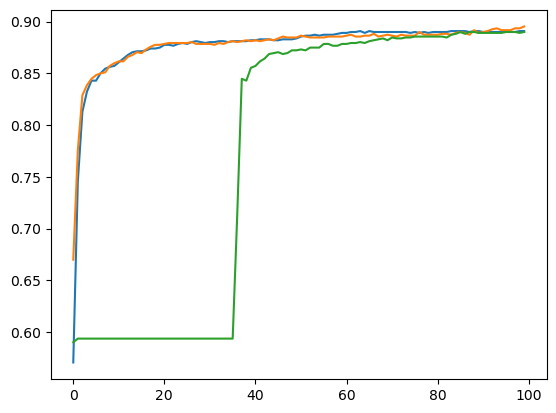

In [123]:
for hist in histories:    
    plt.plot(hist.history['accuracy']) 

### VII. Train with pretrained models

In [124]:
model_libs = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LGBMClassifier': LGBMClassifier(verbosity = 0)
    }

In [125]:
accuracies = dict()
for model_name, model in model_libs.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_cv)
    accuracy = accuracy_score(y_cv, y_pred)
    accuracies[model_name] = (model, accuracy)


    print(f"{model_name} - Accuracy: {accuracy*100:.2f}%")

LogisticRegression - Accuracy: 84.84%
DecisionTreeClassifier - Accuracy: 79.79%
RandomForestClassifier - Accuracy: 88.03%
GradientBoostingClassifier - Accuracy: 87.50%
AdaBoostClassifier - Accuracy: 87.50%
ExtraTreesClassifier - Accuracy: 86.70%
XGBClassifier - Accuracy: 85.90%
LGBMClassifier - Accuracy: 86.70%


### VIII. Evaluate and select the optimal model
To evaluate the performance, we want to use `evaluate()`

In [126]:
for model_name, model in models.items():
    loss, accuracy, mse = model.evaluate(X_test, y_test)
    accuracies[model_name] = (model, accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.8869 - loss: 0.3389 - mse: 0.0958
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.8901 - loss: 0.3145 - mse: 0.0908
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - accuracy: 0.8864 - loss: 0.3442 - mse: 0.0995


In [127]:
opt_model = None
highest = 0
for model_name, model_acc in accuracies.items():
    model, acc = model_acc
    if acc > highest:
        opt_model = model
        highest = acc
    
    print(f"The accuracy in {model_name} using cv set is {acc * 100:.2f}%")
opt_model

The accuracy in LogisticRegression using cv set is 84.84%
The accuracy in DecisionTreeClassifier using cv set is 79.79%
The accuracy in RandomForestClassifier using cv set is 88.03%
The accuracy in GradientBoostingClassifier using cv set is 87.50%
The accuracy in AdaBoostClassifier using cv set is 87.50%
The accuracy in ExtraTreesClassifier using cv set is 86.70%
The accuracy in XGBClassifier using cv set is 85.90%
The accuracy in LGBMClassifier using cv set is 86.70%
The accuracy in Model_1 using cv set is 88.56%
The accuracy in Model_2 using cv set is 88.56%
The accuracy in Model_3 using cv set is 88.03%


<Sequential name=Model_1, built=True>

In [128]:
model_name = opt_model
print(f"The model chosen is Model {model_name}")

The model chosen is Model <Sequential name=Model_1, built=True>


In [129]:
model.evaluate(X_train, y_train)
model.evaluate(X_cv, y_cv)
model.evaluate(X_test, y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - accuracy: 0.8933 - loss: 0.3294 - mse: 0.0945
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.8829 - loss: 0.4129 - mse: 0.1176
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.8864 - loss: 0.3442 - mse: 0.0995


[0.35648617148399353, 0.8803191781044006, 0.1031566709280014]

###IX. Search the optimal decision boundary

We want to choose the right decision boundary. By default, we can use 0.50 as the boundary point but we want see if we can improve our model's performance by optimizing the boundary point.

<span style="color:red">HOW</span>

In [130]:
val, max_correct, y_pred, result = search_boundary(model, X_test, y_test)

print(f"The optimal decision boundary for {model_name}: {val} with {max_correct} correct predictons.")

<Sequential name=Model_3, built=True> (376, 69) (376,)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The optimal decision boundary for <Sequential name=Model_1, built=True>: 0.6 with 334 correct predictons.


We  plot the number of correct predictions vs. the possible decision value (in decimal).

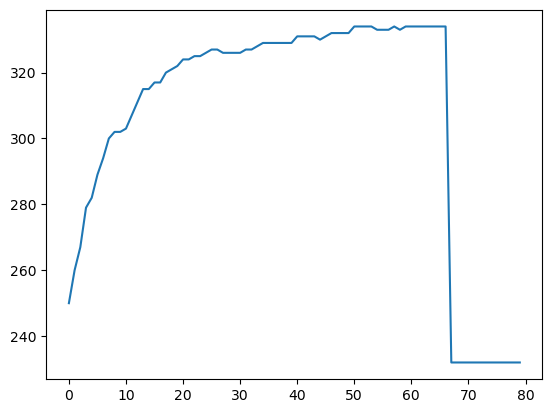

In [131]:
plt.plot(result);

In [132]:
y_predict = [1 if x >= val else 0 for x in y_pred]

Accuracy from the prediction: 88.83%


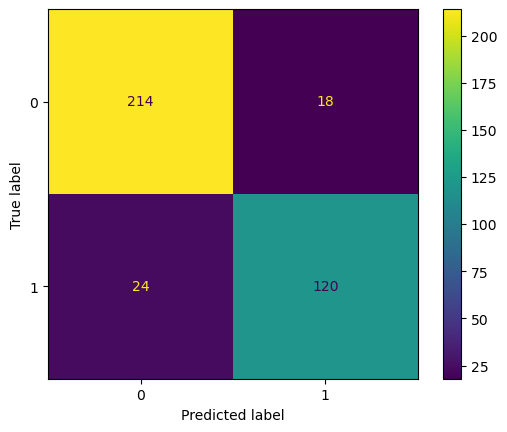

In [133]:
y_actual = np.array(y_test)
mat = confusion_matrix(y_actual, y_predict)
print(f"Accuracy from the prediction: {(mat.trace()/ mat.sum())*100:.2f}%")

disp = ConfusionMatrixDisplay(confusion_matrix = mat)
disp.plot();

  

In the confusion matrix, the diagonals are the number of correct predictions. We want to sum the total correct predictions using the `trace()`.

### Modifications
* During the training, we reduce the hidden layer to 2 with fewer units.
* During the prediction, we used the optimal decision value by adjusting the step increments by 0.01. We found that the the sweet spot is at `{val}` instead of 0.05
* Feature reduction. We also reduce the number of features from 17 to 3 features. By reducing the number of features, our model's accuracy increased by 9%.

### Things to improve
* Use polynomial to see if features needed to be changed.
* Apply existing models and evaluate their performance.